# Yankees Hits Since The All Star Break

### Sometimes as fans we come up with conclusions with no statisical facts, just a feeling. With my New York Yankees having a historic slump, my father and I were convineced that the Yankees were mostly getting base hits with two outs and no body on base since the All Star Break. So I wanted to put our theory to the test. Today we will be pulling data from every hit the Yankees have had since the All Star Break to see if we are right or wrong. This is a great exercise in learning how to use APIs, functions, dicts, pandas, and some Plotly. Jupyter doesn't have spell check so I apologize in advance for any spelling erros. 

# First need to import the neccesary libraries

In [61]:
import requests
import json
from datetime import date, timedelta
import pandas as pd
import plotly.graph_objects as go

## Since it's the Yankees we are looking at we are going to make a global variable called my_team and make it equal to the New York Yankees. But if you want to find some similar statistics for another team just swap out the Yankees with another team. Everything will still work.

In [10]:
global my_team
my_team = 'New York Yankees'

## Next we are going to create a function that will allow us to pull games from a specific date range. We are creating a function so we can call this in the future

In [11]:
def schedule_grab(start_date,end_date):
    link = 'http://statsapi.mlb.com/api/v1/schedule/games/?sportId=1&startDate=' + start_date + '&endDate=' + end_date
    response = requests.get(link)
    days_game = response.json()
    return days_game

## We are interested in the games from the All Star Break. To do that we will need to use datetime to get todays date, subtract a day to make sure we are only getting games that have finished, format it in a way that the api likes, and finally run out schedule grab function

In [12]:
yesterday = date.today() - timedelta(days=1)
yesterday = str(yesterday.strftime('%Y-%m-%d'))

In [13]:
all_star_break = '2022-7-19'

In [14]:
days_game = schedule_grab(all_star_break,yesterday)

In [15]:
#days_game

## Now we want to create a function that will return links to all the individual games the yankees have played. This is something we may use in the future so we will make a function that loops through our schedule and returns a list of game links. To confirm we are locating the correct games we are going to return a list of the links and a list of the teams who played in those games. If all went right all the games should have the Yankees in it. 

In [16]:
def game_links_grab(schedule):
    game_links = []
    game_teams = []
    
    for x in schedule['dates']:
    
        for y in x['games']:

            home_team = y['teams']['home']['team']['name']
            away_team = y['teams']['away']['team']['name']

            if home_team == my_team or away_team == my_team:
                link = y['link']
                teams = away_team + ' vs ' + home_team
                game_teams.append(teams)
                game_links.append(link)
                
    return game_links, game_teams 


In [17]:
yankee_games = game_links_grab(days_game)

In [18]:
yankee_games[0]

['/api/v1.1/game/662776/feed/live',
 '/api/v1.1/game/662775/feed/live',
 '/api/v1.1/game/661072/feed/live',
 '/api/v1.1/game/661057/feed/live',
 '/api/v1.1/game/661056/feed/live',
 '/api/v1.1/game/662438/feed/live',
 '/api/v1.1/game/662420/feed/live',
 '/api/v1.1/game/661257/feed/live',
 '/api/v1.1/game/661256/feed/live',
 '/api/v1.1/game/661255/feed/live',
 '/api/v1.1/game/661254/feed/live',
 '/api/v1.1/game/661268/feed/live',
 '/api/v1.1/game/661253/feed/live',
 '/api/v1.1/game/661293/feed/live',
 '/api/v1.1/game/661946/feed/live',
 '/api/v1.1/game/661949/feed/live',
 '/api/v1.1/game/661948/feed/live',
 '/api/v1.1/game/662152/feed/live',
 '/api/v1.1/game/662148/feed/live',
 '/api/v1.1/game/662185/feed/live',
 '/api/v1.1/game/663177/feed/live',
 '/api/v1.1/game/663176/feed/live',
 '/api/v1.1/game/663175/feed/live',
 '/api/v1.1/game/661283/feed/live',
 '/api/v1.1/game/661250/feed/live',
 '/api/v1.1/game/661266/feed/live',
 '/api/v1.1/game/661265/feed/live',
 '/api/v1.1/game/661319/feed

In [19]:
len(yankee_games[1])

31

## Our goal is to see how many hits the Yankees have had when there are less than two outs and compare with how many they have when there are 2. But we need to figure out what the API considers a hit. To do this we will pull information from each game and see what feilds we get for the result of each play. We will do this in a function just incase we will need this in the future.

In [20]:
def feilds_return(link):
    url = 'http://statsapi.mlb.com' + link
    response = requests.get(url)
    game = response.json()
        
    feilds = []
    
    for x in game['liveData']['plays']['allPlays']:
        try:
            event = x['result']['event']
            if event not in feilds:
                feilds.append(event)
        except:
            pass
        
    return feilds
        
    

In [21]:
game_links = yankee_games[0]
all_feilds = []

for link in game_links:
    new_feilds = feilds_return(link)
    for x in new_feilds:
        if x not in all_feilds:
            all_feilds.append(x)

In [22]:
all_feilds

['Walk',
 'Flyout',
 'Hit By Pitch',
 'Single',
 'Strikeout',
 'Lineout',
 'Pop Out',
 'Double',
 'Double Play',
 'Grounded Into DP',
 'Groundout',
 'Home Run',
 'Intent Walk',
 'Forceout',
 'Field Error',
 'Catcher Interference',
 'Strikeout Double Play',
 'Caught Stealing 2B',
 'Sac Fly',
 'Fielders Choice',
 'Sac Bunt',
 'Triple',
 'Fielders Choice Out',
 'Bunt Pop Out',
 'Caught Stealing 3B',
 'Bunt Groundout']

## Here is where things can get subjective. Although I played baseball as a kid and have watched it all my life, unfortunately I'm not stats expert nor a data scientiest. Maybe an aspiring one but not an actual one. But we need to decide what we are going to consider a hit, an out, and anything that is neither. We are going to make this a global variable to insure we call these in our future functions. We will also loop each list to confirm we didn't miss anything from the original list.

In [23]:
global hits, outs, other, not_found
hit_list = ['Single','Double','Triple','Home Run',]
out_list = ['Flyout','Strikeout','Lineout','Pop Out','Double Play','Grounded Into DP','Groundout','Forceout','Strikeout Double Play','Fielders Choice Out','Bunt Pop Out','Bunt Groundout']
other_list = ['Walk','Hit By Pitch','Intent Walk','Field Error','Catcher Interference','Caught Stealing 2B','Sac Fly','Fielders Choice','Sac Bunt','Caught Stealing 3B','Game Advisory']
not_found = []

In [24]:
pop_all_feilds = all_feilds

for x in hit_list:
    if x in pop_all_feilds:
        pop_all_feilds.remove(x)
    else:
        print(x)
        
for x in out_list:
    if x in pop_all_feilds:
        pop_all_feilds.remove(x)
    else:
        print(x)
        
for x in other_list:
    if x in pop_all_feilds:
        pop_all_feilds.remove(x)
    else:
        print(x)
        
pop_all_feilds

Game Advisory


[]

## Now the meat and potatoes, we need to identify each at bat the Yankees have had. To do that we need to identify if the Yankees are the home or not. Once we figure that out we will loop through each at bat and identify if the player got a hit or not. If the player did get a hit we will identify if it was with less than 2 outs or with two outs. We will add each hit to a dict under their respective category.

In [42]:
def game_stats(link):
    url = 'http://statsapi.mlb.com' + link
    response = requests.get(url)
    game = response.json()
    
    date = game['gameData']['datetime']['officialDate']
    
    away_team = game['gameData']['teams']['away']['name']
    away_team_score = game['liveData']['linescore']['teams']['away']['runs']
    away_team_full = away_team + ': ' + str(away_team_score)
    
    home_team = game['gameData']['teams']['home']['name']
    home_team_score = game['liveData']['linescore']['teams']['home']['runs']
    home_team_full = home_team + ': ' + str(home_team_score)

    
    if away_team == my_team:
        home = False
    if home_team == my_team:
        home = True
        
    yankee_atbats = []

    for x in game['liveData']['plays']['allPlays']:
        if home is True:
            if x['about']['halfInning'] == 'bottom':
                yankee_atbats.append(x)
        if home is False:
            if x['about']['halfInning'] == 'top':
                yankee_atbats.append(x)

        hits_results = {'less_than_two':[],
                        'two_out':[]}
    

    for x in yankee_atbats:
    
        if x['result']['event'] in hit_list:
            outs = x['count']['outs']
            if outs < 2:
                result = stat_creation(x)
                hits_results['less_than_two'].append(result)
            elif outs == 2:
                result = stat_creation(x)
                hits_results['two_out'].append(result)
            else:
                print(outs)

        elif x['result']['event'] in out_list:
            pass

        else:
            not_found.append(x['result']['event'])
            
    less_than_two_hits = len(hits_results['less_than_two'])
    two_out_hits = len(hits_results['two_out'])
    
    hits_results.update({'date': date,
                         'home': home_team_full,
                         'away': away_team_full,
                         'stats':
                         {'less_than_two_hits':less_than_two_hits,
                          'two_out_hits':two_out_hits}})
    
    return link, hits_results


In [43]:
def stat_creation(at_bat):
    batter = at_bat['matchup']['batter']['fullName']
    inning = at_bat['about']['inning']
    result = at_bat['result']['description']

    on_base = ''
    
    try:
        on_first = at_bat['matchup']['postOnFirst']['fullName']
        if on_first != batter:
            on_first = True
        else:
            on_first = False
            
    except:
        on_first = False

    try:
        on_second = at_bat['matchup']['postOnSecond']['fullName']
        if on_second != batter:
            on_second = True
        else:
            on_second = False
    except:
        on_second = False

    try:
        on_third = at_bat['matchup']['postOnThird']['fullName']
        if on_third != batter:
            on_third = True
        else:
            on_third = False
            
    except:
        on_third = False

    if on_first is False and on_second is False and on_third is False:
        if 'scores' in result:
            on_base = True
        else:
            on_base = False
    else:
        on_base = True

    full_stat = {'batter': batter,
                 'inning': inning,
                 'result': result,
                 'onbase': on_base}    
    
    return full_stat

In [44]:
all_stats = {}
for link in game_links:
    howd_they_do = game_stats(link)
    try:
        all_stats.update({howd_they_do[0]:howd_they_do[1]})
    except:
        pass

3


In [47]:
#all_stats

## Now we will create a dict that will give us the amount of games the Yankees had more hits with less than two outs, with two outs, and the same amount of hits

In [58]:
hits_dict = {'less_2': 0,
            'equal_2': 0,
            'same': 0}

In [59]:
for x in all_stats:
    less_than_two = all_stats[x]['stats']['less_than_two_hits']
    two_out = all_stats[x]['stats']['two_out_hits']
    
    if less_than_two > two_out:
        count = hits_dict['less_2']
        new_count = count + 1
        hits_dict.update({'less_2':new_count})
        
    elif less_than_two < two_out:
        count = hits_dict['equal_2']
        new_count = count + 1
        hits_dict.update({'equal_2':new_count})
        
    elif less_than_two == two_out:
        count = hits_dict['same']
        new_count = count + 1
        hits_dict.update({'same':new_count})
    
    else:
        print('???')
    

In [60]:
hits_dict

{'less_2': 22, 'equal_2': 5, 'same': 4}

## At the time of me creating this I got {'less_2': 22, 'equal_2': 5, 'same': 4}. Looks like my father an I were wrong. Lets create a nice pandas dataframe and a chart to visualize our data.

In [55]:
games_df = pd.DataFrame(columns = ['Date', 'Less_2', 'Equal_2','Players_On','Yankee_Score','Opponent_Score'])
for x in all_stats:
    
    if my_team in all_stats[x]['home']:
        yankee_score = all_stats[x]['home'].split(': ')[1]
        opponent_score = all_stats[x]['away'].split(': ')[1]
    else:
        yankee_score = all_stats[x]['away'].split(': ')[1]
        opponent_score = all_stats[x]['home'].split(': ')[1]
                      
    players_on = 0
    
    for at_bats in all_stats[x]['less_than_two']:
        if at_bats['onbase'] is True:
            players_on = players_on + 1
            
    for at_bats in all_stats[x]['two_out']:
        if at_bats['onbase'] is True:
            players_on = players_on + 1
            
    date = all_stats[x]['date']
    less_2 = all_stats[x]['stats']['less_than_two_hits']
    equal_2 = all_stats[x]['stats']['two_out_hits']
    new_row = {'Date':date, 
               'Less_2':less_2, 
               'Equal_2': equal_2, 
               'Players_On':players_on, 
               'Yankee_Score': yankee_score,
               'Opponent_Score': opponent_score
              }
    games_df = games_df.append(new_row, ignore_index=True)


In [56]:
games_df

,Date,Less_2,Equal_2,Players_On,Yankee_Score,Opponent_Score
0,2022-07-21,3,2,2,2,3
1,2022-07-21,7,1,4,5,7
2,2022-07-22,4,5,5,7,6
3,2022-07-23,10,1,4,3,6
4,2022-07-24,6,7,9,6,0
5,2022-07-26,8,1,2,3,6
6,2022-07-27,4,3,3,2,3
7,2022-07-28,1,1,0,1,0
8,2022-07-29,6,5,7,11,5
9,2022-07-30,7,1,3,8,2


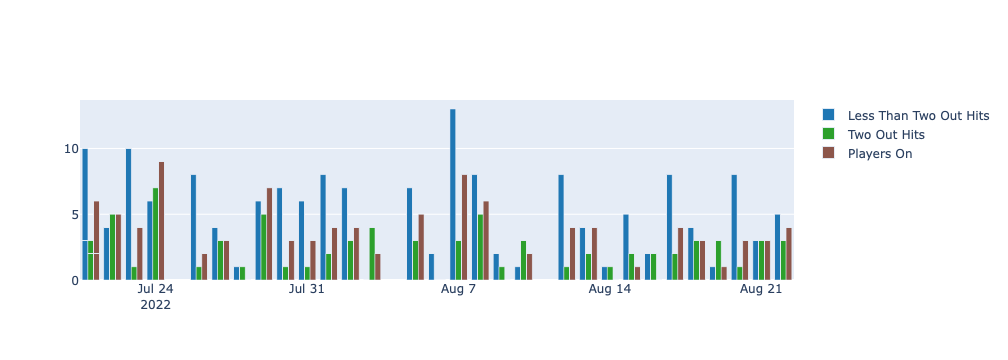

In [57]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=games_df['Date'],
    y=games_df['Less_2'],
    name='Less Than Two Out Hits',
    marker_color='#1f77b4'
))
fig.add_trace(go.Bar(
    x=games_df['Date'],
    y=games_df['Equal_2'],
    name='Two Out Hits',
    marker_color='#2ca02c'
))
fig.add_trace(go.Bar(
    x=games_df['Date'],
    y=games_df['Players_On'],
    name='Players On',
    marker_color='#8c564b'
))


## There is clearly a reason why the stats guys make more money than us fans.